### Import Packages

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print("Packages Imported")

Packages Imported


### Inputs

In [3]:
cwd = os.getcwd()
in_subpath = "output_final\\1 - Initial Testing"
in_file = "sir_250000_beta_random_gamma_fixed_n_range"
in_path = os.path.join(cwd, in_subpath, in_file)

print("Input Path Set")

Input Path Set


### Load Data

In [4]:
# LOAD DATA
print("\nLoading Data")
data_raw = pd.read_csv('output_sir_monte_carlo_test.csv', delimiter=',', header=None)
data_eval = data_raw.to_numpy()
print("Data Loaded")

indx_p_start = np.where(data_eval[0] == 666)[0][0]
indx_i_start = np.where(data_eval[0] == 777)[0][0]
indx_end = np.where(data_eval[0] == 999)[0][0]


Loading Data
Data Loaded


### Process Data

In [5]:
n_days = 120

param_start = indx_p_start + 1
param_end = indx_i_start - indx_p_start

i_start = param_end + 1
i_end = i_start + n_days

y_data = data_eval[:, param_start:param_end]
x_raw = data_eval[:, i_start:i_end]

x_total = data_eval[:, i_start:i_start + 365]

n = len(x_total[0])
N0 = 4500000

x_data = x_raw / N0

print("\nTesting Data:")
print("Sample: {0}".format(x_data.shape))


Testing Data:
Sample: (1, 120)


### Run Model

In [6]:
model1 = tf.keras.models.load_model(in_path)
model1.summary()

predictions_data = model1.predict(x_data) # make predictions on test set to compare with actual

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 20,354
Trainable params: 20,354
Non-trainable params: 0
_________________________________________________________________


### Simulate ODE

In [8]:
n_pred = predictions_data[0, 0]
beta_pred = predictions_data[0, 1]
gamma_pred = 1.0 / 11

n_real = y_data[0, 0]
beta_real = y_data[0, 1]
gamma_real = 1.0 / 11

N = N0 * n_pred
I0 = 1
S0 = N - I0
R0 = 0

S = []
I = []
R = []

S.append(S0)
I.append(I0)
R.append(R0)

for i in range(0, n - 1):
    dS = - (beta_pred * S[i] * I[i] / N)
    dI = (beta_pred * S[i] * I[i] / N) - (gamma_pred * I[i])
    dR = (gamma_pred * I[i])

    Snew = S[i] + dS
    Inew = I[i] + dI
    Rnew = R[i] + dR

    S.append(Snew)
    I.append(Inew)
    R.append(Rnew)

print("\nSample Length \t n - Actual \t n - NN \t Beta - Actual \t Beta - NN")
print("{0} \t\t {1:.8f} \t {2:.8f} \t {3:.8f} \t {4:.8f}".format(n, y_data[0, 0], predictions_data[0, 0], y_data[0, 1], predictions_data[0, 1]))

# CALCUATE RELATIVE ERROR
error_n = 100 * abs(n_real - n_pred) / n_real
error_beta = 100 * abs(beta_real - beta_pred) / beta_real

print("\nError n: {0:.2f}%".format(error_n))
print("Error Beta: {0:.2f}%".format(error_beta))

# CALCULATE MSE
x_smple = x_total.reshape(n, )
mse = sum(np.abs(I - x_smple)**2) / len(I)
print("\nMSE: {0}".format(mse))


Sample Length 	 n - Actual 	 n - NN 	 Beta - Actual 	 Beta - NN
365 		 0.04949551 	 0.05061105 	 0.35497724 	 0.35534942

Error n: 2.25%
Error Beta: 0.10%

MSE: 208684.3701974774


### Plot Results

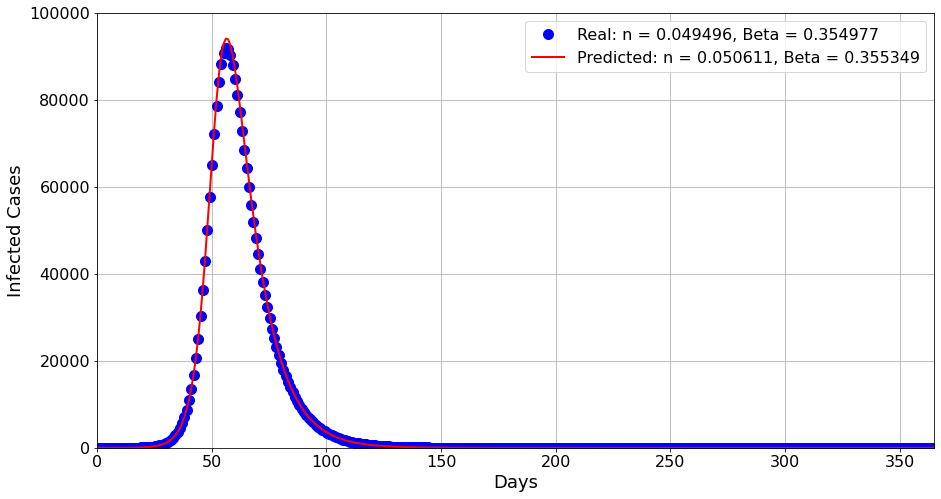

In [12]:
t_required = np.linspace(0, n, n)

plt.figure(figsize=(15,8))
plt.plot(t_required, x_smple, "ob", ms=10, label="Real: n = {0:.6f}, Beta = {1:.6f}".format(n_real, beta_real))
plt.plot(t_required, I, "-r", linewidth=2, label="Predicted: n = {0:.6f}, Beta = {1:.6f}".format(n_pred, beta_pred))
plt.xlabel("Days", fontsize=18)
plt.ylabel("Infected Cases", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 365)
plt.ylim(0, 100000)
plt.legend(loc='upper right', fontsize=16)
plt.grid()
plt.show()